In [2]:
# Basic data handling and scientific computing
import numpy as np
import pandas as pd
import scipy.io
import scipy.stats as stats
import h5py
import os
import glob
import re
import gzip
import math

# Machine learning and data analysis tools
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

# Statistical methods
from scipy.stats import zscore, pearsonr, spearmanr
from scipy.ndimage import gaussian_filter
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.interpolate import interpn

# Tensor and decomposition
import tensorly as tl
from tensorly.decomposition import non_negative_parafac

# Other utilities
import pyBigWig
from scipy.io import savemat
import textwrap

# Suppress warnings if necessary
import warnings
warnings.filterwarnings('ignore')

# Custom or other specific imports
import hicstraw  # Assumed specific to your use case

#This block imports the 3omics data for 153 single cells of two cell types.

base_directory = '/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/'

def normalize_matrix_columns(A):
    """
    Normalize each column of the matrix so that each has a norm of one.
    
    Parameters:
    - A: a 2D NumPy array (matrix)
    
    Returns:
    - normalized_A: a matrix where each column of A has been divided by its L2 norm
    """
    # Calculate the L2 norm for each column
    column_norms = np.linalg.norm(A, axis=0)
    
    # Avoid division by zero
    if np.any(column_norms == 0):
        raise ValueError("One or more columns have zero norm. Cannot normalize those columns.")
    
    # Normalize each column by its norm
    normalized_A = A / column_norms
    
    return normalized_A

def calculate_matrix(file_path):
    # Initialize an empty list to store the data
    data = []

    # Read the compressed file using gzip
    with gzip.open(file_path, 'rt') as file:
        for line in file:
            # Split the line into fields
            fields = line.strip().split('\t')

            # Extract relevant entries for calculations
            numerator_indices = range(6, len(fields), 2)
            denominator_indices = range(7, len(fields), 2)

            row_data = []
            for num_idx, denom_idx in zip(numerator_indices, denominator_indices):
                numerator = float(fields[num_idx])
                denominator = float(fields[denom_idx])

                # Check if denominator is zero, set entry to 0, else perform the division
                row_data.append(0 if denominator == 0 else numerator / denominator)

            data.append(row_data)

    # Convert the list of lists into a NumPy array
    data_matrix = np.array(data)

    return data_matrix

file_path = base_directory + 'b37.autosome.1Mb_interval.add_value.methy.bed.gz'
methylation_matrix_1Mb = normalize_matrix_columns(calculate_matrix(file_path))
print(methylation_matrix_1Mb.shape)

# Define the path to the file
file_path = '/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/filtered_bam_list.txt'

# Initialize an empty list to store the prefixes
prefixes = []

try:
    # Open and read the file with a different encoding
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        for line in file:
            # Strip the newline character and append to the prefixes list
            prefixes.append(line.strip())
except UnicodeDecodeError:
    print("Failed to decode file with ISO-8859-1. Trying another method.")

# Print the list of prefixes
print(len(prefixes))

import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from config_and_print import filtered_list, chrom_file, resolutions, normalization

output_directory = '../../projects/single_cell_files'

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

print(f"Resolutions from config: {resolutions}")
resolution_str = resolutions[0]
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, label = parse_resolution(resolution_str)

import h5py
import matplotlib.pyplot as plt
import numpy as np



prefix_file_path = '../../projects/single_cell_files/filtered_bam_list.txt'
# Read prefixes from the file
with open(prefix_file_path, 'r') as f:
    prefixes = [line.strip() for line in f] 

file_list = prefixes

chromosomes_info = {
    '1': 249250621,
    '2': 243199373,
    '3': 198022430,
    '4': 191154276,
    '5': 180915260,
    '6': 171115067,
    '7': 159138663,
    '8': 146364022,
    '9': 141213431,
    '10': 135534747,
    '11': 135006516,
    '12': 133851895,
    '13': 115169878,
    '14': 107349540,
    '15': 102531392,
    '16': 90354753,
    '17': 81195210,
    '18': 78077248,
    '19': 59128983,
    '20': 63025520,
    '21': 48129895,
    '22': 51304566,
}

########################################################################
# create the cell type dictionary
# [TO DO] This needs to be replaced with SNPS code 
########################################################################
# Define the path file with prefixes and colors in the following form
#1       sc1.ACTTGA      red
#2       sc1.GCCAAT      red
#3       sc1.TAGCTT      red
#4       sc10.TAGCTT     blue
#
filename = '../../bin/name.order.HCG_methy.with_color.txt'

# Initialize an empty dictionary to store cell ID and color
cell_color_dict = {}

# Open and read the file
with open(filename, 'r') as file:
    for line in file:
        # Split the line into parts
        parts = line.strip().split()
        # Extract cell ID and color
        cell_id = parts[1]
        color = parts[2]
        # Store in dictionary
        cell_color_dict[cell_id] = color

# Define the path to the tensor sample order file
#This file contains the prefixes in the form
#sc11.ACTTGA
#sc11.CGATGT
#sc11.GCCAAT
#
tensor_order_filename = f'{output_directory}/filtered_bam_list.txt'

# Initialize a list to store the 1s and 0s
color_vector = []

# Open and read the tensor sample order file
with open(tensor_order_filename, 'r') as file:
    for line in file:
        sample_id = line.strip()  # Remove any trailing newlines or spaces
        if sample_id in cell_color_dict and cell_color_dict[sample_id] == 'red':
            color_vector.append(1)
        else:
            color_vector.append(0)

# Output the color vector to check
print(len(color_vector))

# Create a mapping dictionary
color_mapping = {
    'red': 'imr90',
    'blue': 'gm12878'
}

# Update the dictionary using the mapping
updated_cell_color_dict = {key: color_mapping[value] for key, value in cell_color_dict.items()}

from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# Set the desired rank
rank = 2

# Perform Non-negative Matrix Factorization (NMF)
model = NMF(n_components=rank, init='random', random_state=0)
W = model.fit_transform(methylation_matrix_1Mb)
H = model.components_

# Check the shapes of W and H to confirm the decomposition
print("Shape of W:", W.shape)
print("Shape of H:", H.shape)

# Assuming W is already computed

# Create a color vector based on the index values
indices = np.arange(W.shape[0])
color_vector_W = indices  # Using indices as colors

# Normalize the color vector to range [0, 1] for use in colormap
color_vector_W_normalized = (color_vector_W - color_vector_W.min()) / (color_vector_W.max() - color_vector_W.min())

# Scatter plot for W factors with coloring by index
plt.figure(figsize=(8, 6))
plt.scatter(W[:, 0], W[:, 1], c=color_vector_W_normalized, cmap='viridis', alpha=0.7)
plt.title('Scatter Plot of W Factors')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Index')
plt.grid(True)
plt.show()


# Scatter plot for H factors
plt.figure(figsize=(8, 6))
plt.scatter(H[0, :], H[1, :], c = color_vector, alpha=0.7)
plt.title('Scatter Plot of H Factors')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()




/home/dwk681/.conda/envs/multiomics6/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-17 22:08:14.534976: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 22:08:14.539041: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-17 22:08:14.835586: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-17 22:08:14.845954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performanc

(2897, 129)
129
bam_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam'
methy_directory='/home/dwk681/workspace/cluster_cells_from_GSE189158_NOMe_HiC/filesFromCluster/bam/methylation/filter_low_qual'
software_directory='../../bin/softwarefiles'
chrom_file='../../bin/softwarefiles/hg19.autosome.chrom.sizes'
fragments_file='../../bin/softwarefiles/hg19_DpnII.txt'
output_directory='../../projects/single_cell_files'
hg19_fa_url='ftp://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz'
filtered_list='../../projects/single_cell_files/filtered_bam_list.txt'
schicluster_env='schicluster2'
bisulfite_env='bisulfitehic27'
min_high_quality_reads='250000'
resolutions='1000000:1Mb'
impute='True'
cluster_compartments='False'
cumulant='False'
iterations='900'
chromosomes=1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
dark_regions_hg19_url='https://www.encodeproject.org/files/ENCFF000EHJ/@@download/ENCFF000EHJ.bigWig'
mappability_threshold='0

In [11]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from config_and_print import filtered_list, chrom_file, resolutions, normalization

output_directory = '../../projects/single_cell_files'

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

print(f"Resolutions from config: {resolutions}")
resolution_str = resolutions[0]
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, label = parse_resolution(resolution_str)

import h5py
import matplotlib.pyplot as plt
import numpy as np



prefix_file_path = '../../projects/single_cell_files/filtered_bam_list.txt'
# Read prefixes from the file
with open(prefix_file_path, 'r') as f:
    prefixes = [line.strip() for line in f] 

file_list = prefixes

chromosomes_info = {
    '1': 249250621,
    '2': 243199373,
    '3': 198022430,
    '4': 191154276,
    '5': 180915260,
    '6': 171115067,
    '7': 159138663,
    '8': 146364022,
    '9': 141213431,
    '10': 135534747,
    '11': 135006516,
    '12': 133851895,
    '13': 115169878,
    '14': 107349540,
    '15': 102531392,
    '16': 90354753,
    '17': 81195210,
    '18': 78077248,
    '19': 59128983,
    '20': 63025520,
    '21': 48129895,
    '22': 51304566,
}

########################################################################
# create the cell type dictionary
# [TO DO] This needs to be replaced with SNPS code 
########################################################################
# Define the path file with prefixes and colors in the following form
#1       sc1.ACTTGA      red
#2       sc1.GCCAAT      red
#3       sc1.TAGCTT      red
#4       sc10.TAGCTT     blue
#
filename = '../../bin/name.order.HCG_methy.with_color.txt'

# Initialize an empty dictionary to store cell ID and color
cell_color_dict = {}

# Open and read the file
with open(filename, 'r') as file:
    for line in file:
        # Split the line into parts
        parts = line.strip().split()
        # Extract cell ID and color
        cell_id = parts[1]
        color = parts[2]
        # Store in dictionary
        cell_color_dict[cell_id] = color

# Define the path to the tensor sample order file
#This file contains the prefixes in the form
#sc11.ACTTGA
#sc11.CGATGT
#sc11.GCCAAT
#
tensor_order_filename = f'{output_directory}/filtered_bam_list.txt'

# Initialize a list to store the 1s and 0s
color_vector = []

# Open and read the tensor sample order file
with open(tensor_order_filename, 'r') as file:
    for line in file:
        sample_id = line.strip()  # Remove any trailing newlines or spaces
        if sample_id in cell_color_dict and cell_color_dict[sample_id] == 'red':
            color_vector.append(1)
        else:
            color_vector.append(0)

# Output the color vector to check
print(len(color_vector))

# Create a mapping dictionary
color_mapping = {
    'red': 'imr90',
    'blue': 'gm12878'
}

# Update the dictionary using the mapping
updated_cell_color_dict = {key: color_mapping[value] for key, value in cell_color_dict.items()}



#view methylation UMPAPs
scatter = plt.scatter(umap_results_1Mb[:, 0], umap_results_1Mb[:, 1], alpha=0.6, c=color_vector, cmap='plasma')
plt.title('UMAP of 1Mb Methylation Matrix\nOne Dot For Each Sample')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.show()

Resolutions from config: ('1000000:1Mb',)
Extracted resolution string: 1000000:1Mb
129


NameError: name 'umap_results_1Mb' is not defined

In [24]:
import h5py
import numpy as np
from tensorly.decomposition import non_negative_parafac
import tensorly as tl


# Ensure that TensorLy uses the correct backend (usually numpy)
tl.set_backend('numpy')


chrom = 11  # Assuming chromosome 11

# Specify the desired rank for the NTF
rank = 50  # Number of low-rank factors

# List to store the factor matrices
factor_3_matrices = []

hdf5_directory = '/home/dwk681/workspace/hypermatrix_test/hypermatrix/projects/single_cell_files/'
hdf5_filename = hdf5_directory + 'chromosome_11_tensor_hic.h5'
# Load the tensor and perform NTF
with h5py.File(hdf5_filename, 'r') as hdf5_file:
    # Load the tensor data for chromosome 11 into memory
    chromosome_tensor = hdf5_file[f'chromosome_{chrom}'][()]
    print(f"Shape of chromosome {chrom} tensor:", chromosome_tensor.shape)
    
    # Perform Non-negative Tensor Factorization (rank-20)
    weights, factors = non_negative_parafac(chromosome_tensor, rank=rank, init='random', random_state=0)
    factor_3 = factors[2]  # Extract the third factor matrix (corresponding to the samples)
    
    # Append the extracted factor matrix to the list
    factor_3_matrices.append(factor_3)

# Convert the list to a NumPy array (if needed) for further processing
factor_3_matrices = np.array(factor_3_matrices)

# Print the shape of the extracted factor matrix
print("Shape of the extracted factor matrix:", factor_3.shape)


Shape of chromosome 11 tensor: (135, 135, 129)
Shape of the extracted factor matrix: (129, 50)


In [28]:
factor_3_matrices[0][:,0]

array([9.72111864e-03, 6.18311770e-01, 1.22990083e-12, 4.84434040e-02,
       6.49043428e-03, 1.27159294e+00, 1.30511814e+00, 9.00405167e-05,
       1.37504525e-16, 1.98801150e-01, 1.80140505e+00, 5.84671466e-02,
       4.15111440e-01, 5.25083815e-04, 1.29598527e+00, 2.39081652e-01,
       1.41323850e-31, 1.51861164e+00, 8.14381421e-07, 4.21480384e-16,
       1.09369711e-06, 9.74731261e-01, 3.96646206e-12, 1.07614700e+00,
       6.73771665e-01, 3.01773103e-01, 3.47350630e-17, 2.00654099e-01,
       1.25262988e-31, 8.27304091e-01, 1.62528917e+00, 1.33613664e+00,
       1.30775628e-08, 9.46411063e-13, 6.10116806e-12, 3.03848617e-01,
       1.45506722e-03, 7.12457950e-01, 6.33321538e-01, 7.87202633e-07,
       5.56445875e-19, 1.08987784e+00, 1.29392807e-31, 9.68199158e-02,
       1.42927981e+00, 8.43282763e-02, 3.43089659e-02, 8.45028047e-01,
       2.42164978e-01, 1.67127047e-01, 1.09499602e-04, 4.06683489e-15,
       9.62958497e-28, 9.87325518e-69, 2.06721797e-18, 4.23826101e-01,
      

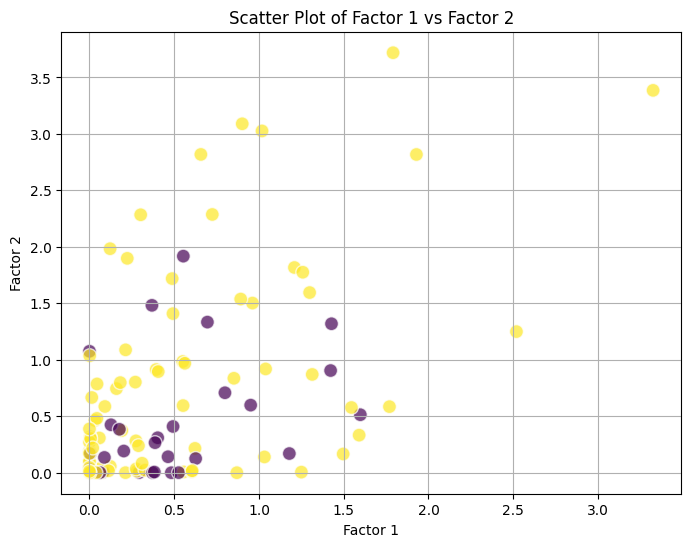

In [29]:
import matplotlib.pyplot as plt

# Extract the first factor matrix
factor_matrix = factor_3_matrices[0]

# Scatter plot of the first two columns
plt.figure(figsize=(8, 6))
plt.scatter(factor_matrix[:, 18], factor_matrix[:, 19], c = color_vector, alpha=0.7, edgecolors='w', s=100)

# Add labels and title
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.title('Scatter Plot of Factor 1 vs Factor 2')

# Show grid
plt.grid(True)

# Display the plot
plt.show()


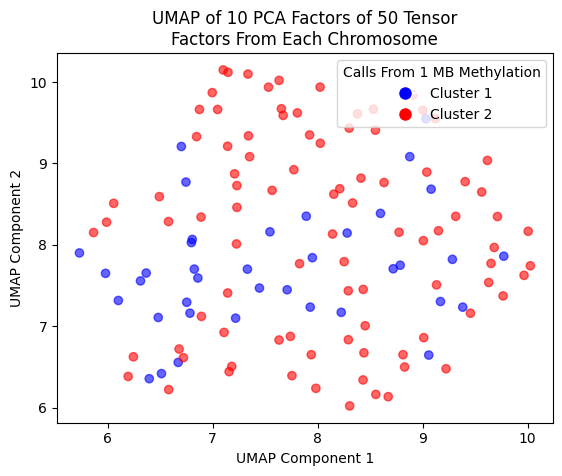

In [30]:
pca = PCA(n_components=10)
pca_results = pca.fit_transform(factor_3_matrices[0])

reducer = umap.UMAP(n_neighbors=50, n_components=2, random_state=42)  # 2D UMAP, set random state for reproducibility
umap_tensor = reducer.fit_transform(pca_results)

# Assuming 'umap_results' and 'color_vector' are defined
# Define colors explicitly for the categories
colors = ['blue' if x == 0 else 'red' for x in color_vector]

# Scatter plot
scatter = plt.scatter(umap_tensor[:, 0], umap_tensor[:, 1], alpha=0.6, c=colors)
plt.title('UMAP of 10 PCA Factors of 50 Tensor\nFactors From Each Chromosome')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Cluster 1'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cluster 2')]
plt.legend(handles=legend_elements, title='Calls From 1 MB Methylation')

plt.show()